# QuantBet challenge submission example

The aim here is to fit the model using the training data and make predictions for the home team win, draw, and away team win outcomes (also known as the "1X2" market) on the testing data.

This example uses [Stan](https://mc-stan.org) for parameter inference on the training data and to make predictions on the test data.

In [1]:
library(rstan)
library(bayesplot)
library(ggplot2)
library(readr)
library(dplyr)

options(mc.cores = parallel::detectCores())
rstan_options(auto_write = TRUE)

train_data <- read_csv("https://competition.quantbet.com/data/training.csv", col_types = cols())
test_data <- read_csv("https://competition.quantbet.com/data/test.csv", col_types = cols())

Loading required package: StanHeaders
Loading required package: ggplot2
rstan (Version 2.19.2, GitRev: 2e1f913d3ca3)
For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)
This is bayesplot version 1.7.0
- Online documentation and vignettes at mc-stan.org/bayesplot
- bayesplot theme set to bayesplot::theme_default()
   * Does _not_ affect other ggplot2 plots
   * See ?bayesplot_theme_set for details on theme setting

Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



## A (very) brief look at the data

In [2]:
head(train_data)

division,date,home_team,away_team,full_time_home_goals,full_time_away_goals,half_time_home_goals,half_time_away_goals
<chr>,<date>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
I2,2010-08-20,Atalanta,Vicenza,2,0,2,0
I2,2010-08-22,Triestina,Albinoleffe,1,1,0,0
I2,2010-08-22,Reggina,Crotone,0,0,0,0
I2,2010-08-22,Portogruaro,Cittadella,2,0,1,0
I2,2010-08-22,Pescara,Siena,1,1,0,1
I2,2010-08-22,Frosinone,Empoli,2,3,1,1


In [3]:
head(test_data)

division,date,home_team,away_team
<chr>,<date>,<chr>,<chr>
I1,2016-08-20,Juventus,Fiorentina
I1,2016-08-20,Roma,Udinese
I1,2016-08-21,Atalanta,Lazio
I1,2016-08-21,Bologna,Crotone
I1,2016-08-21,Chievo,Inter
I1,2016-08-21,Empoli,Sampdoria


**Note that some teams in the test data to not appear in the training data!**

In [4]:
train_teams <- unique(c(train_data$home_team, train_data$away_team))
test_teams <- unique(c(test_data$home_team, test_data$away_team))

new_test_teams <- setdiff(test_teams, train_teams)

new_test_teams

[1] "Benevento" "Pisa"      "Spal"      "Venezia"   "Cremonese" "Foggia"

## Model

Here we consider a simple Poisson model, for more details see e.g. [Dixon and Coles (1997)](https://rss.onlinelibrary.wiley.com/doi/10.1111/1467-9876.00065).

In short, we assume that the number of goals scored by the home and away teams are independent and follow a Poisson distribution. The rates of this Poisson distribution are:

\begin{align*}
\log(\lambda_h) &= \alpha + \gamma + attack_h - defence_a \\
\log(\lambda_a) &= \alpha + attack_a - defence_h
\end{align*}

for the home ($h$) and away ($a$) teams respectively, where $\alpha$ is an
intercept term, $\gamma$ is the home advantage term, $attack_k$ is the
attacking strength of team $k$, and $defence_k$ is the defensive strength of
team $k$.

We posit the following prior structure:

\begin{align*}
\alpha &\sim Normal(0, 1^2) \\
\gamma &\sim Normal(0, 1^2) \\
attack_k &\sim Normal(0, \sigma_{teams}^2) \, \text{for all teams} \, k \\
defence_k &\sim Normal(0, \sigma_{teams}^2) \, \text{for all teams} \, k \\
\sigma_{teams} &\sim HalfNormal(1^2)
\end{align*}

which is defined in the followng stan code:

In [5]:
writeLines(readLines("example.stan"))


functions {
    int[] clip_difference(int[] x, int[] y, int low, int hi) {
        int n = size(x);
        int clipped_difference[n];
        for (i in 1:n) {
            clipped_difference[i] = min(max(x[i] - y[i], low), hi);
        }
        return clipped_difference;
    }
}

data {
    int<lower = 0> num_teams;

    // train data
    int<lower = 0> num_train_examples;

    int<lower = 0> train_home_goals[num_train_examples];
    int<lower = 0> train_away_goals[num_train_examples];

    int<lower = 1, upper = num_teams> train_home_ix[num_train_examples];
    int<lower = 1, upper = num_teams> train_away_ix[num_train_examples];

    // test data
    int<lower = 0> num_test_examples;

    int<lower = 1, upper = num_teams> test_home_ix[num_test_examples];
    int<lower = 1, upper = num_teams> test_away_ix[num_test_examples];
}

parameters {
    real intercept;
    real home_advantage;
    vector[num_teams] attack;
    vector[num_teams] defence;
    real<lower = 0.0> sigma_teams;
}

m

Note that the stan code also creates out of sample predictions via the `generated quantities` block. The `away_draw_home` array has length the number of fixtures in the test set, and each element contains -1, 0, or 1 for a simulated test fixture outcome of away win, draw, or home win respectively.

## Fit the model

**REMEMBER TO SET THE SEED**

In [6]:
teams <- sort(unique(c(train_teams, test_teams)))

stan_data <- list(
    num_teams = length(teams),

    # train data
    num_train_examples = nrow(train_data),

    train_home_goals = train_data$full_time_home_goals,
    train_away_goals = train_data$full_time_away_goals,
    train_home_ix = unclass(factor(train_data$home_team, levels = teams)),
    train_away_ix = unclass(factor(train_data$away_team, levels = teams)),

    # test data
    num_test_examples = nrow(test_data),
    test_home_ix = unclass(factor(test_data$home_team, levels = teams)),
    test_away_ix = unclass(factor(test_data$away_team, levels = teams))
)

model <- stan_model("example.stan")

exclude_pars = c("rep_test_home_goals", "rep_test_away_goals", "test_home_log_rate", "test_away_log_rate")

fit <- sampling(model,
                seed = 42,
                data = stan_data, 
                chains = 8, 
                pars = exclude_pars,
                include = FALSE)

print(fit, pars = "away_draw_home", include = FALSE, probs = c(0.025, 0.5, 0.975))

Inference for Stan model: example.
8 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=8000.

                   mean se_mean   sd     2.5%      50%    97.5% n_eff Rhat
intercept          0.05    0.00 0.04    -0.03     0.05     0.13   915 1.01
home_advantage     0.28    0.00 0.02     0.24     0.28     0.31 10197 1.00
attack[1]         -0.13    0.00 0.09    -0.31    -0.13     0.05  8148 1.00
attack[2]         -0.16    0.00 0.07    -0.30    -0.16    -0.02  5459 1.00
attack[3]          0.02    0.00 0.07    -0.11     0.02     0.14  4253 1.00
attack[4]         -0.11    0.00 0.08    -0.27    -0.11     0.04  5981 1.00
attack[5]         -0.10    0.00 0.06    -0.23    -0.10     0.02  4562 1.00
attack[6]          0.00    0.00 0.20    -0.39     0.00     0.39 10166 1.00
attack[7]         -0.09    0.00 0.07    -0.22    -0.09     0.04  4853 1.00
attack[8]         -0.03    0.00 0.06    -0.15    -0.02     0.09  4745 1.00
attack[9]          0.0

## A quick look at the posterior

In [7]:
posterior <- as.array(fit)

parameter_names <- dimnames(posterior)$parameters

dimnames(posterior)$parameters[grep("^attack\\[", parameter_names)] <- paste0("attack[", teams, "]")
dimnames(posterior)$parameters[grep("^defence\\[", parameter_names)] <- paste0("defence[", teams, "]")

### Convergence

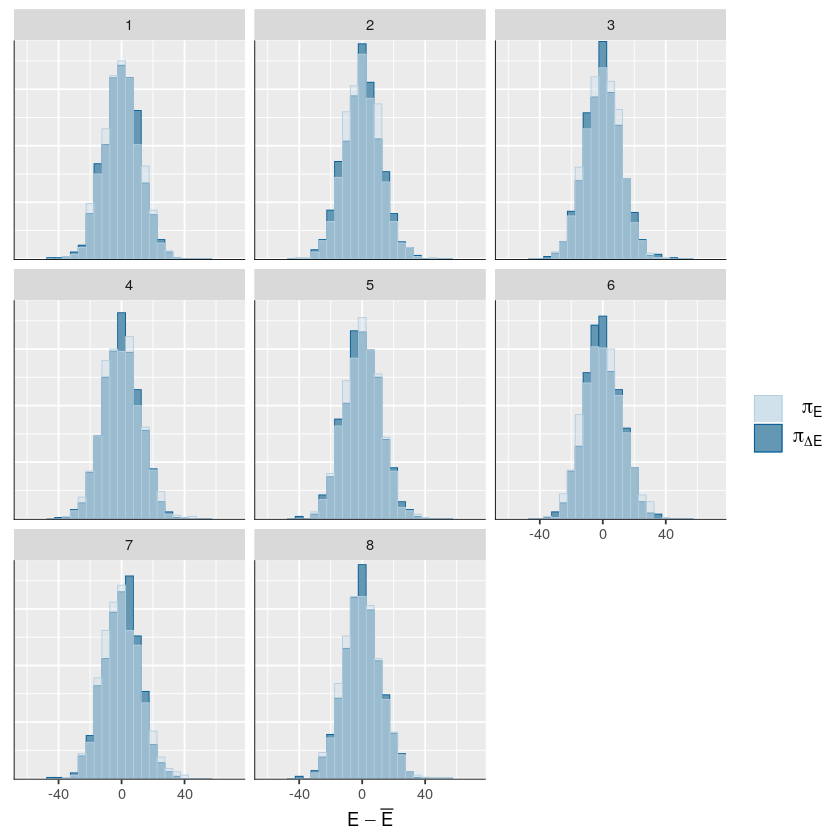

In [8]:
np <- nuts_params(fit)
lp <- log_posterior(fit)

mcmc_nuts_energy(np, lp, binwidth = 5)

### Parameters common to all teams

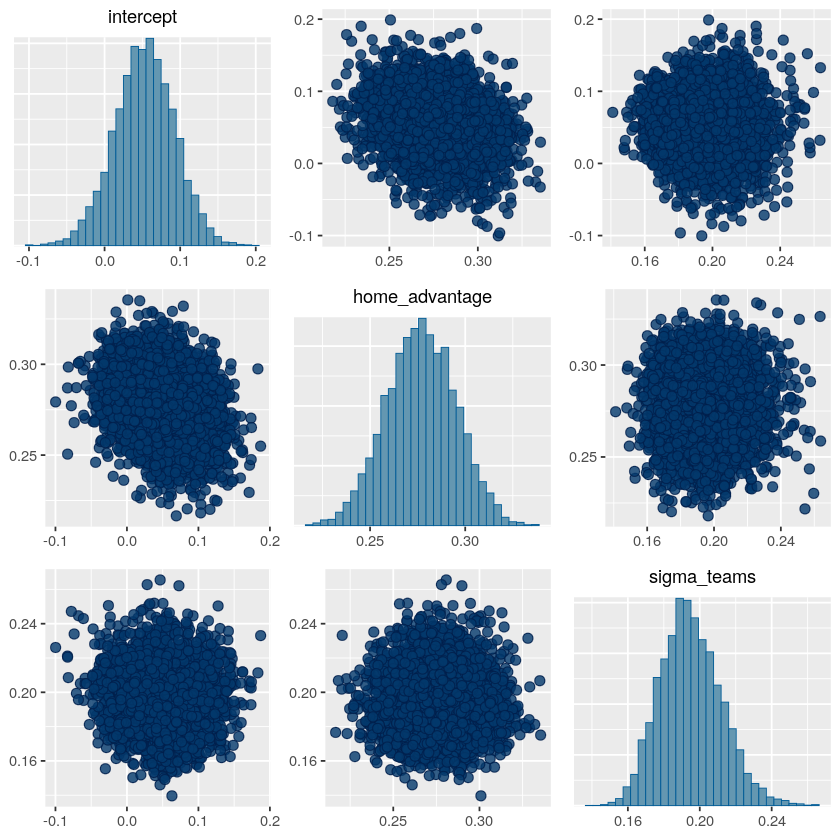

In [9]:
mcmc_pairs(posterior, pars = c("intercept", "home_advantage", "sigma_teams"))

### Team specific parameters

Teams which appear in the test set and not the training set are coloured red.

In [10]:
team_colours <- data.frame(teams) %>%
    mutate(colour = ifelse(teams %in% new_test_teams, "red", "black"))

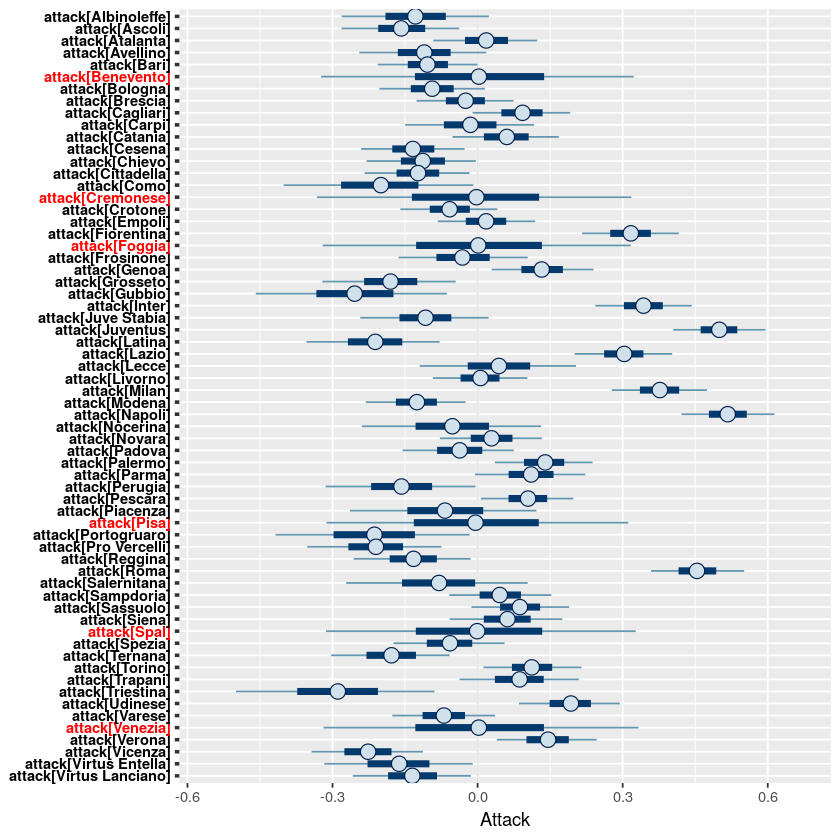

In [11]:
mcmc_intervals(posterior, regex_pars = "^attack") + 
    xlab("Attack") + 
    theme(axis.text.y = element_text(colour = rev(team_colours$colour)))

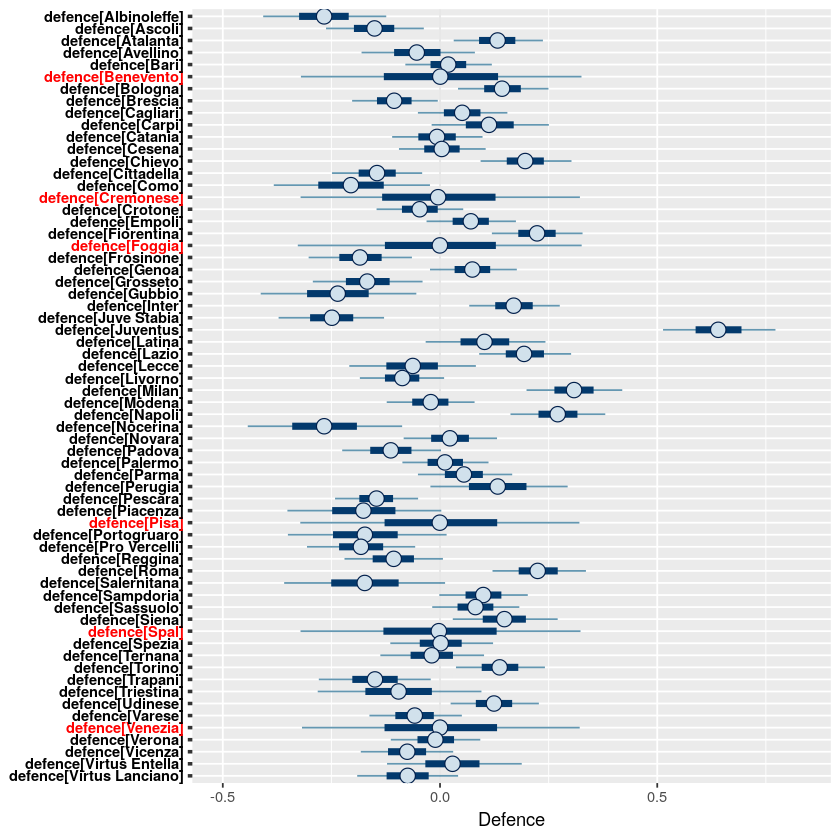

In [12]:
mcmc_intervals(posterior, regex_pars = "^defence") +
    xlab("Defence") +
    theme(axis.text.y = element_text(colour = rev(team_colours$colour)))

## Submission

In [13]:
away_draw_home <- extract(fit, "away_draw_home")[[1]]

submission <- t(apply(away_draw_home, 2, table)) / nrow(away_draw_home)

colnames(submission) <- c("away_win", "draw", "home_win")

head(submission)

away_win,draw,home_win
0.149125,0.236500,0.614375
0.188625,0.219250,0.592125
0.379250,0.281125,0.339625
0.240125,0.287250,0.472625
0.403625,0.283625,0.312750
0.298875,0.275500,0.425625


In [14]:
write_csv(as.data.frame(submission), "example_submission.csv")